In [2]:
import io
import re
import pandas as pd
import numpy as np
import seaborn as sns
import dateutil.parser as dp
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import warnings

from pylab import rcParams
from IPython.core.display import display, HTML
from string import ascii_lowercase as alphabet

In [49]:
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(style="ticks")
matplotlib.style.use('ggplot')

rcParams["patch.force_edgecolor"] = True
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 20
rcParams['axes.facecolor'] = 'white'

### Q1

### a) Importing data:  

In [91]:
health = pd.read_csv('health_survey.csv', encoding='latin')
health = health[[c for c in health.columns if not re.match("^(p\.value|Unnamed)", c)]]
health = health.rename(columns={c: c.replace('percent.', '20').replace('short.', '') for c in health.columns})

health.head(5)

,population,description,group,2016,2015,2014,2013,2012,2011,2006,2007
0,adults,Physically active,Total,50.2,47.7,50.7,52.1,51.7,54.4,52.0,NaN
1,adults,Physically active,Men,53.0,51.0,55.2,55.2,55.8,57.3,55.5,NaN
2,adults,Physically active,Women,47.6,44.5,46.5,49.1,47.9,51.7,48.8,NaN
3,adults,Physically active,15-17,47.1,41.7,49.6,46.7,52.7,58.1,58.6,NaN
4,adults,Physically active,18-24,53.5,49.7,52.6,53.7,54.9,57.4,55.3,NaN


### b) Filtering:

In [92]:
#health.description.unique()

In [93]:
labels = [
    'Current smokers', 
    'Daily smokers',
    'All teeth removed due to decay',
    'Mean number of cigarettes',
    'Heavy smokers',
    'Self-rated health - poor'
]
filtered = health[health.description.isin(labels)].query('group == "Total" and population == "adults"')

filtered

,population,description,group,2016,2015,2014,2013,2012,2011,2006,2007
268,adults,Current smokers,Total,15.7,16.3,16.6,17.4,17.7,18.2,20.1,NaN
292,adults,Daily smokers,Total,13.8,14.2,15.0,15.7,15.6,16.3,18.3,NaN
547,adults,All teeth removed due to decay,Total,6.6,6.4,7.4,6.5,8.1,8.0,8.5,NaN
865,adults,Self-rated health - poor,Total,2.3,2.5,2.4,1.7,2.3,2.5,1.9,NaN
931,adults,Heavy smokers,Total,7.7,7.4,8.2,8.5,9.3,9.6,10.7,NaN
1131,adults,Mean number of cigarettes,Total,10.2,10.2,10.6,10.9,11.2,11.2,11.5,NaN


### c) Wrangling and reshaping

In [94]:
reshaped = filtered[filtered.columns.difference(['group', 'description', 'population'])]
reshaped = reshaped.T.rename(columns=filtered.description.to_dict())

reshaped.index.name = 'Year'
reshaped.columns.name = 'description'
reshaped.sort_index()

reshaped

description,Current smokers,Daily smokers,All teeth removed due to decay,Self-rated health - poor,Heavy smokers,Mean number of cigarettes
Year,,,,,,
2006,20.1,18.3,8.5,1.9,10.7,11.5
2007,NaN,NaN,NaN,NaN,NaN,NaN
2011,18.2,16.3,8.0,2.5,9.6,11.2
2012,17.7,15.6,8.1,2.3,9.3,11.2
2013,17.4,15.7,6.5,1.7,8.5,10.9
2014,16.6,15.0,7.4,2.4,8.2,10.6
2015,16.3,14.2,6.4,2.5,7.4,10.2
2016,15.7,13.8,6.6,2.3,7.7,10.2


### d) Creating a function

In [95]:
def join(ss):
    joined = ', '.join(map(lambda s: '"{0}"'.format(s), ss))
    return '[{0}]'.format(joined)

def wrangle(df, descriptions, groups, populations):
    ds = join(descriptions)
    gs = join(groups)
    ps = join(populations)
    expr = 'description in {0} and group in {1} and population in {2}'.format(ds, gs, ps)

    filtered = df.query(expr)
    filtered = filtered[filtered.columns.difference(['group', 'description', 'population'])]
      
    transposed = filtered.T.rename(columns=df.description.to_dict())
    placeholder = pd.DataFrame(columns=set(descriptions)-set(transposed.columns))
    filled = pd.concat([transposed, placeholder], axis=1, sort=True)
    sorted = filled.sort_index(axis=0)
    
    sorted = sorted.sort_index(axis=1)
    sorted.index.name = 'Year'
    sorted.columns.name = 'description'
    
    return sorted

In [96]:
wrangle(health, labels, ['Total'], ['adults'])

description,All teeth removed due to decay,Current smokers,Daily smokers,Heavy smokers,Mean number of cigarettes,Self-rated health - poor
Year,,,,,,
2006,8.5,20.1,18.3,10.7,11.5,1.9
2007,NaN,NaN,NaN,NaN,NaN,NaN
2011,8.0,18.2,16.3,9.6,11.2,2.5
2012,8.1,17.7,15.6,9.3,11.2,2.3
2013,6.5,17.4,15.7,8.5,10.9,1.7
2014,7.4,16.6,15.0,8.2,10.6,2.4
2015,6.4,16.3,14.2,7.4,10.2,2.5
2016,6.6,15.7,13.8,7.7,10.2,2.3


In [97]:
wrangle(health, labels, ['Men'], ['adults'])

description,All teeth removed due to decay,Current smokers,Daily smokers,Heavy smokers,Mean number of cigarettes,Self-rated health - poor
Year,,,,,,
2006,7.4,21.3,19.5,14.5,12.3,1.9
2007,NaN,NaN,NaN,NaN,NaN,NaN
2011,6.7,19.0,16.7,13.5,12.4,2.3
2012,6.8,18.8,16.2,12.2,12.2,2.1
2013,5.4,19.2,17.2,11.0,11.7,1.7
2014,6.3,18.2,16.1,10.6,11.4,2.4
2015,5.8,18.1,15.6,9.0,10.6,2.0
2016,5.7,17.4,15.1,9.9,10.9,2.2


In [98]:
wrangle(health, labels, ['15-17'], ['children'])

description,All teeth removed due to decay,Current smokers,Daily smokers,Heavy smokers,Mean number of cigarettes,Self-rated health - poor
Year,,,,,,
2006,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,NaN,NaN,NaN,NaN,NaN
2011,NaN,NaN,NaN,NaN,NaN,NaN
2012,NaN,NaN,NaN,NaN,NaN,NaN
2013,NaN,NaN,NaN,NaN,NaN,NaN
2014,NaN,NaN,NaN,NaN,NaN,NaN
2015,NaN,NaN,NaN,NaN,NaN,NaN
2016,NaN,NaN,NaN,NaN,NaN,NaN


### e) Plotting

In [34]:
smoker_labels = [
    'Heavy smokers', 
    'Current smokers',
    'Daily smokers',
    'Mean number of cigarettes',
    'Mostly smoke both manufactured and roll-your own cigarettes'
]
smoker_trend = wrangle(health, smoker_labels, ['Total'], ['adults'])[2:]

ax0 = smoker_trend.plot(kind='line', title='Smokers trend in NZ 2011-2016')
ax0.set_xticklabels([''] + smoker_trend.index.tolist())
ax0.set_ylabel('value')
lg0 = ax0.legend(title='Legend', bbox_to_anchor=(1, 1))

NameError: name 'wrangle' is not defined


* The most obvious trend, as shown above, is that more and more smokers in New Zealand have quit smoking in the last several years. A possible explanation may be the excise increases on tobacco that began in 2010 in New Zealand.
* In contrast, the numnber of people who smoke both manufactured and roll-your own cigarettes goes up oscillatingly each year. A possible reason could be that somkers turning to roll-your-own cigarettes to deal with the price increase.

In [100]:
illness_labels = [
    'Depression',
    'Anxiety disorder',
    'Gout',
    'Psychological distress',
    'High blood pressure (medicated)',
    'High cholesterol (medicated)'
]
illness = wrangle(health, illness_labels, ['Total'], ['adults']).dropna()
illness

description,Anxiety disorder,Depression,Gout,High blood pressure (medicated),High cholesterol (medicated),Psychological distress
Year,,,,,,
2011,6.1,14.3,1.6,16.0,10.5,4.5
2012,6.4,14.5,1.8,15.8,11.0,6.1
2013,8.4,15.5,2.8,15.8,10.8,6.2
2014,7.8,14.6,3.0,16.3,11.3,6.2
2015,9.5,15.4,3.2,16.6,11.5,6.8
2016,10.3,16.7,2.9,16.6,11.5,7.6


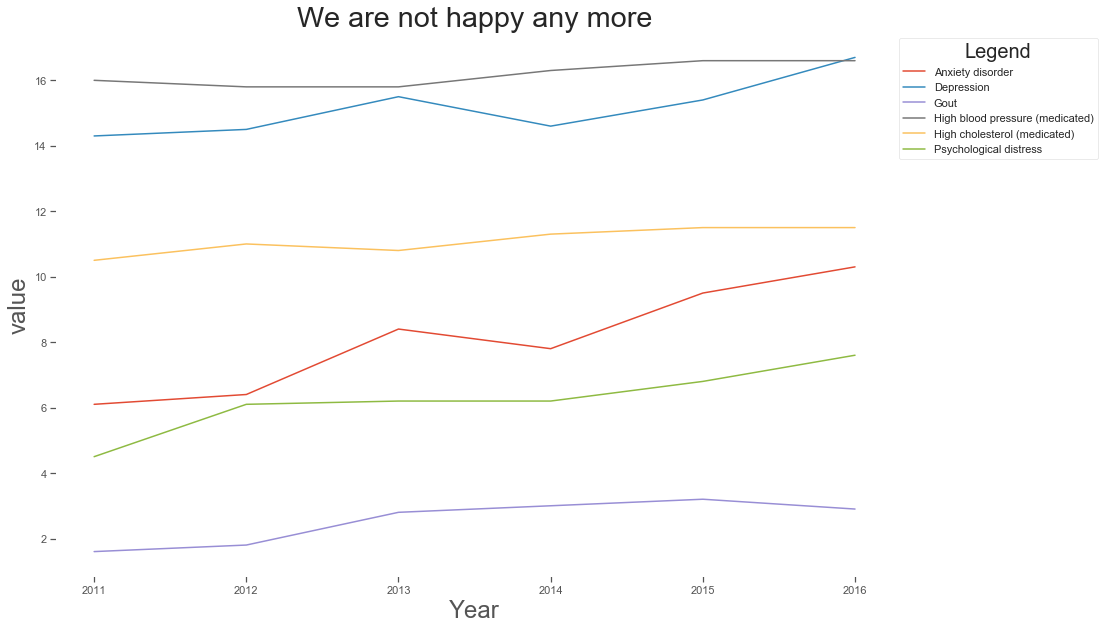

In [180]:
ax1 = illness.plot(kind='line', title='We are not happy any more')
ax1.set_xticklabels([''] + illness.index.tolist())
ax1.set_ylabel('value')
lg1 = ax1.legend(title='Legend', bbox_to_anchor=(1, 1))

* More and more people as shown above are afflicted by mood or mental problems such as depression', anxiety disorder and psychological distress etc.
* Depression and anxiety disorder present quite similar trend.

---

## Question 2

### Wrangling

In [11]:
#helpers

class Child:
    
    def __init__(self, name, year, gender, id):
        self.name = name
        self.year = year
        self.gender = gender
        self.id = id   
    
    def __repr__(self):
        return "%s.%s.%s.%s" % (self.name, self.id, self.gender, self.year)

def children(sheet, gender):
    st = sheet.rename(columns={k: v for v, k in enumerate(sheet.columns)})
    rs = list(range(6, 106, 1))
    cs = list(range(2, 197, 3))
    return [Child(name=st.at[r, c], id=st.at[r, c+1], year=(c-2)//3+1954, gender=gender) for c in cs for r in rs]

In [12]:
#load
url='https://smartstart.services.govt.nz/assets/files/Top-100-girls-and-boys-names-since-1954.xlsx'
fs = pd.read_excel(url, sheet_name="Girls' Names")
ms = pd.read_excel(url, sheet_name="Boys' Names")

In [13]:
# wrangling
bs = children(fs, 'Female') + children(ms, 'Male')
names = pd.DataFrame(
    {
        'name': 
            [b.name for b in bs], 
        'no.': 
            [b.id for b in bs], 
        'year': 
            [b.year for b in bs],
        'sex': 
            [b.gender for b in bs]
    }
)

In [14]:
names.head(10)

,name,no.,year,sex
0,Christine,779,1954,Female
1,Susan,735,1954,Female
2,Margaret,562,1954,Female
3,Judith,531,1954,Female
4,Jennifer,460,1954,Female
5,Mary,423,1954,Female
6,Elizabeth,419,1954,Female
7,Patricia,408,1954,Female
8,Linda,394,1954,Female
9,Barbara,382,1954,Female


In [104]:
names.tail(10)

,name,no.,year,sex
12990,Phoenix,54,2018,Male
12991,Kingston,54,2018,Male
12992,Harley,54,2018,Male
12993,Adam,54,2018,Male
12994,Fletcher,53,2018,Male
12995,Alex,52,2018,Male
12996,Kayden,51,2018,Male
12997,Grayson,50,2018,Male
12998,David,50,2018,Male
12999,Patrick,49,2018,Male


In [105]:
names.year.unique()

array([1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
      dtype=int64)

In [15]:
names.sex.unique()

array(['Female', 'Male'], dtype=object)

In [16]:
len(names)

13000

### Analysis - Favourite letters

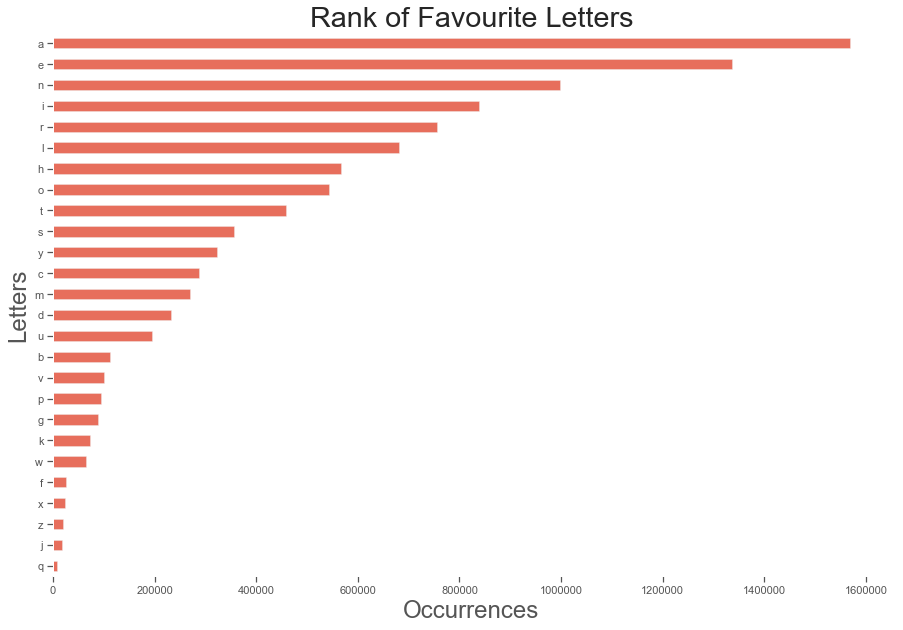

In [35]:
favourite_letters = names.copy()

for letter in alphabet:
    favourite_letters[letter] = [n.count(letter) for n in favourite_letters.name] * favourite_letters['no.']

favourite_by_year = favourite_letters.loc[:, favourite_letters.columns != 'no.'].groupby(['year']).sum()
favourite_all_time = pd.DataFrame({'all': favourite_by_year.sum()})

_ = favourite_all_time.sort_values('all').plot(kind='barh', title='Rank of Favourite Letters', figsize=(15, 10), alpha=.8)
_.set_ylabel('Letters')
_.set_xlabel('Occurrences')
_.get_legend().remove()

* A, E and N are the top 3 letters that New Zealand people like most when naming babys for the last 60 years. The top 1 letter A occurrs more than 1,500,000 times in our data set.
* Perhaps Kiwi dislikes letter Q, because it apprears less than 10,000 times. This fact makes it the last one of the rank.  

### Analysis -Multivariate Analysis

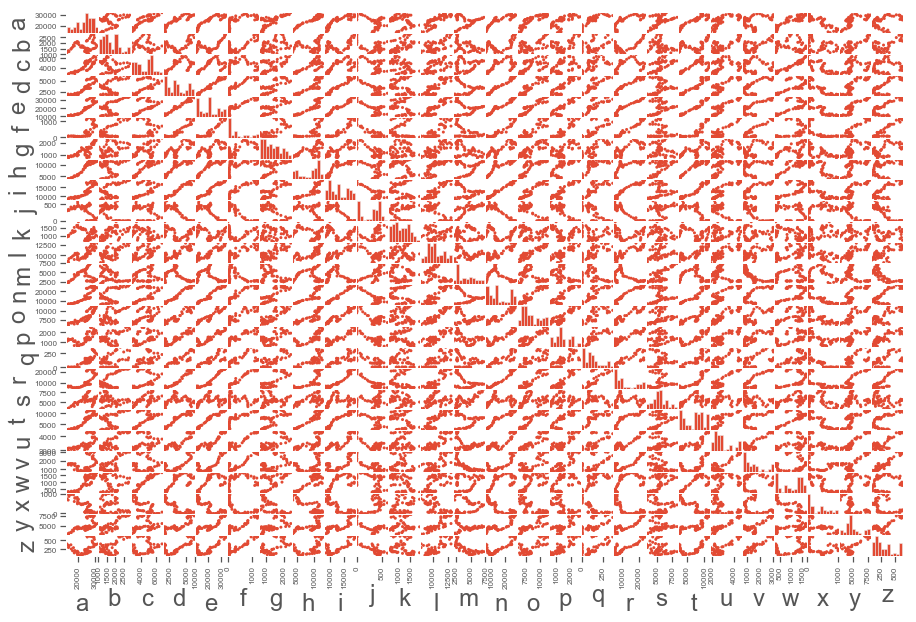

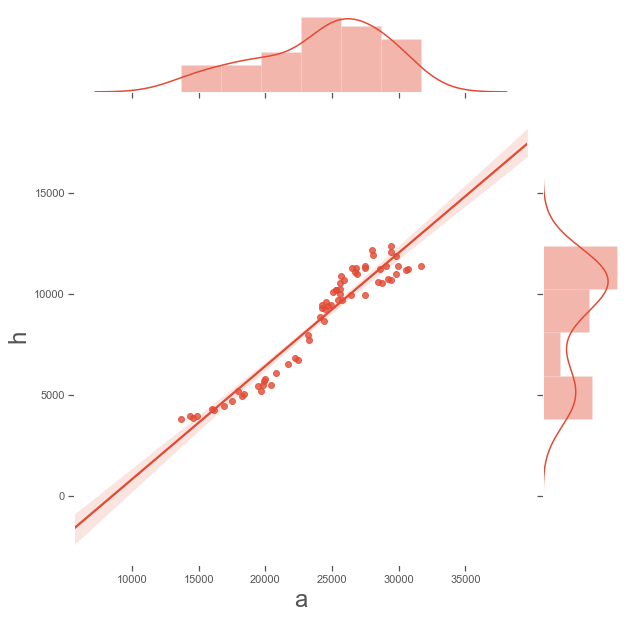

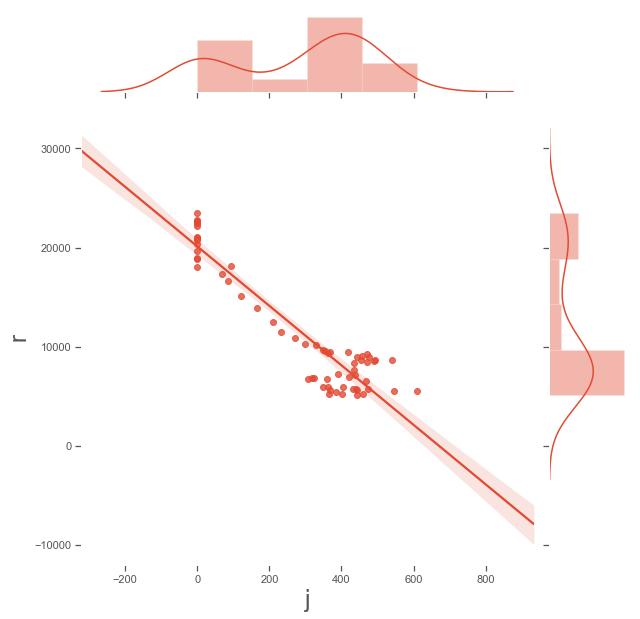

In [36]:
_ = pd.plotting.scatter_matrix(favourite_by_year, alpha=1, diagonal='hist')
_ = sns.jointplot("a", "h", favourite_by_year, kind='reg', height=9)
_ = sns.jointplot("j", "r", favourite_by_year, kind='reg', height=9)

* Dddddddddddddddddddddddd

### Analysis -Prefix and Suffix

In [37]:
#add head and tail into df
parts = names.copy()
parts['head3'] = [n[:+3].lower() for n in parts.name]
parts['tail3'] = [n[-3:].lower() for n in parts.name]

parts.head(5)

,name,no.,year,sex,head3,tail3
0,Christine,779,1954,Female,chr,ine
1,Susan,735,1954,Female,sus,san
2,Margaret,562,1954,Female,mar,ret
3,Judith,531,1954,Female,jud,ith
4,Jennifer,460,1954,Female,jen,fer


In [38]:
# returns the top x parts from year specified
def top_parts_by_year(col, year, no=3):
    return parts[parts.year==year].groupby([col]).sum().sort_values('no.', ascending=False)[0:no].index.tolist()

#
def prepare_df_for_plot(df, col, top_parts):
    d = df.copy()
    full_index = pd.MultiIndex.from_product([d[col].unique(), d['year'].unique()])
    d = d[d[col].isin(top_parts)][['no.', col, 'year']].groupby([col, 'year']).sum().reindex(full_index)
    d.index.names = [col, 'year']
    d = d.reset_index().fillna(0)
    d['no.'] = d['no.'].astype(int)
    d = d.pivot(columns=col, index='year', values='no.')
    return d

# plot
def plot_trend(df, name):
    _ = df.plot(kind='line', figsize=(15, 8), title=name)
    __ = _.set_ylabel('Occurrences')
    __ = _.set_xlabel('Year')
    return _

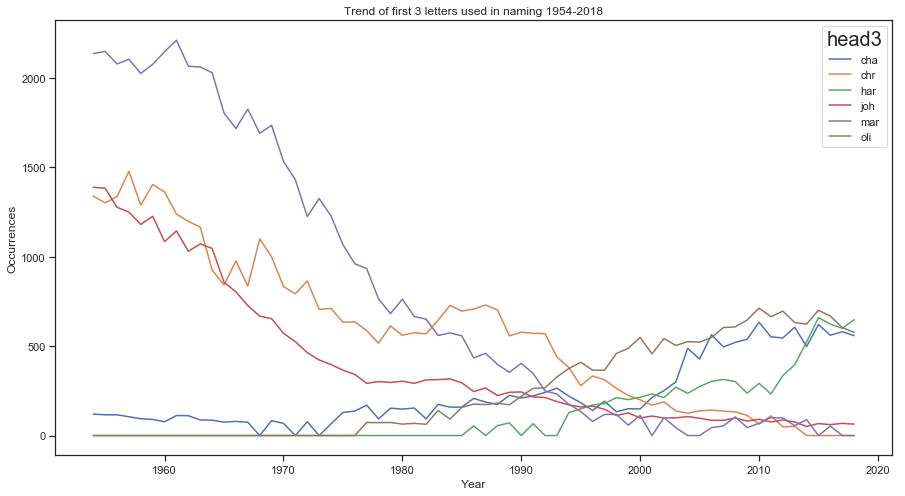

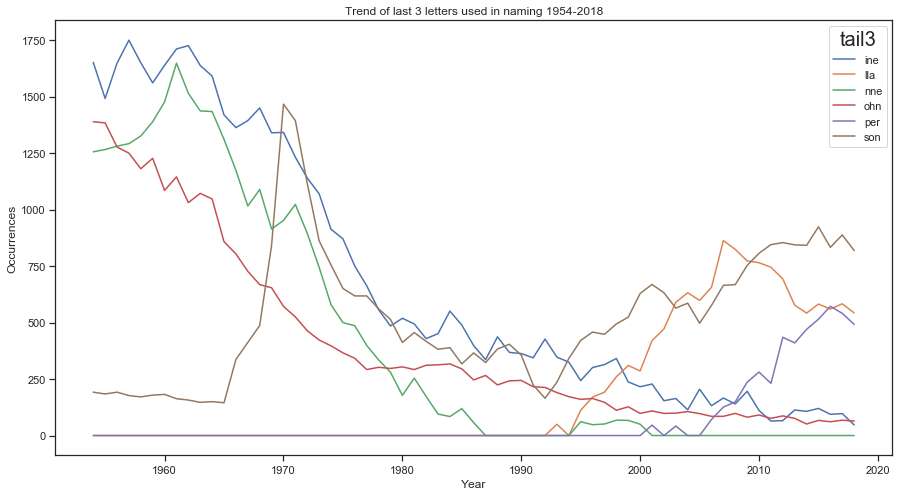

In [30]:
heads = top_parts_by_year('head3', 1954) + top_parts_by_year('head3', 2018)
head_df = parts[parts.head3.isin(heads)]
head_df = prepare_df_for_plot(head_df, 'head3', heads)
plot_trend(head_df, 'Trend of first 3 letters used in naming 1954-2018')

tails = top_parts_by_year('tail3', 1954) + top_parts_by_year('tail3', 2018)
tail_df = parts[parts.tail3.isin(tails)]
tail_df = prepare_df_for_plot(tail_df, 'tail3', tails)
plot_trend(tail_df, 'Trend of last 3 letters used in naming 1954-2018')

* Ddddddddddd

---

## Question 3

# GINI Index and how it relates to indicators of poverty and income

### 1 Introduction 

Since developed by Corrado GINI in 1912, GINI index, a.k.a Gini coefficient, has been widely used as an indicator of economic inequality. This report attempts to investigate the GINI Index trend of the last 35 years in New Zealand as well as to explore and study the relationships between GINI index and indicators of poverty and income.

### 2 Data wrangling

 * User function `find_number` is defined to extract number from string such as B3.4, 56c, etc
 * `DataFrame` object `documentation` has been built from 'Data documentation' for quick look up later
 * Two dictionaries are constructed for renaming the columns
 * Cells with value like '-', '???', 'None' are replaced by `NaN`
 * Column 'year' has been parsed, converted into integer and set as index
 * Nuisance characters have been cleaned by calling function `find_number`
 * All `pandas.Series` have been converted to numerical
 * Columns and rows with `NaN` more than `threshold` have been dropped
 * The rest `NaN` have been replaced with method `bfill`
 * Two `DataFrame` objects are defined to hold the data set, one with column names like 'ho0', 'po9', etc, another with column names filled with Indicator name (alternative) as recorded in 'Data documentation'

In [39]:
def find_number(c):
    '''
    Returns the matched number found
    '''
    if type(c) == str:
        matches = re.findall("[+-]?\d+\.?\d*", c)
        return matches[0] if (len(matches) > 0) else c
    return c

In [40]:
# Construct two dictionaries for renaming the columns, one using aliases like ho, po, etc, another Indicator name (alternative)

sheets = ['Income and wealth', 'Poverty', 'Housing', 'Labour', 'Education', 'Health']
docs = {s[:2].lower(): pd.read_excel('Data documentation.xlsx', sheet_name=s) for s in sheets}

for k in docs:
    docs[k]['sheet'] = k
    docs[k]['alias'] = k + docs[k].index.astype(str)

documentation = pd.concat(docs.values())
documentation = documentation[documentation['Column name in dataset'].notnull()]

aliases = {r['Column name in dataset']: r.alias for _, r in documentation.iterrows()}
indicators = {r['Column name in dataset']: r['Indicator name (alternative)'] for _, r in documentation.iterrows()}

In [41]:
# Data loading and wrangling

nz = pd.read_csv('nz_indicators.csv', encoding='latin', na_values=['-', '???', 'None', 'NaN', 'NAN'])

nz['year'] = [dp.parse(nz.at[r,'year']).year for r in range(0, len(nz))]
nz.set_index('year', inplace=True)
nz.sort_index(inplace=True)

nz = nz.applymap(find_number)
nz = nz.convert_objects(convert_numeric=True)
nz = nz.dropna(axis=1, thresh=18).dropna(axis=0, thresh=18).fillna(method='bfill')

nz_by_aliases = nz.rename(columns=aliases)
nz_by_indicators = nz.rename(columns=indicators)

### 3 Analysis and discussion


#### 3.1 Univariate analysis on GINI

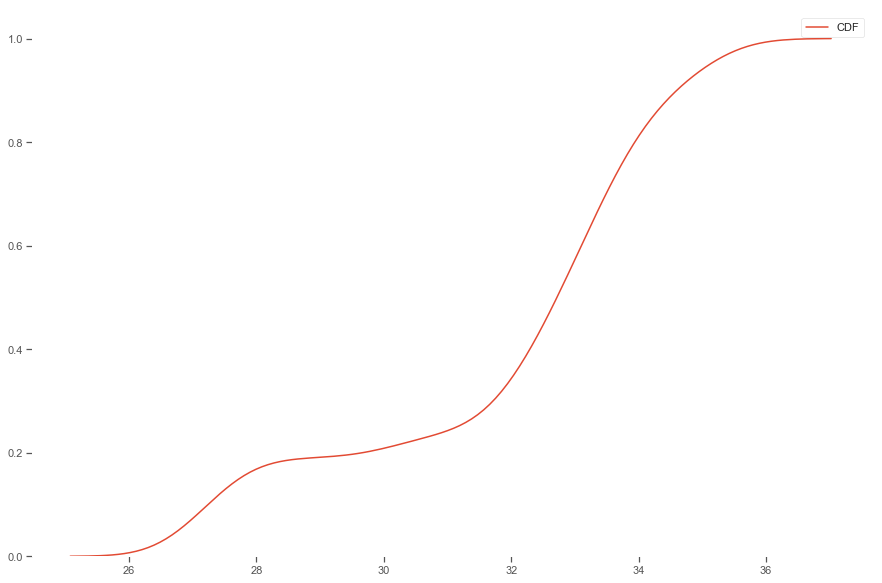

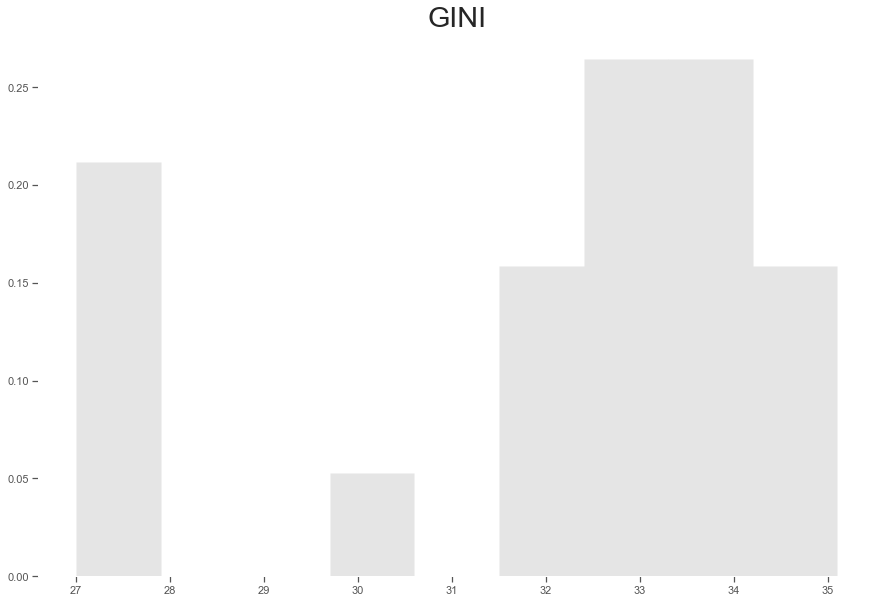

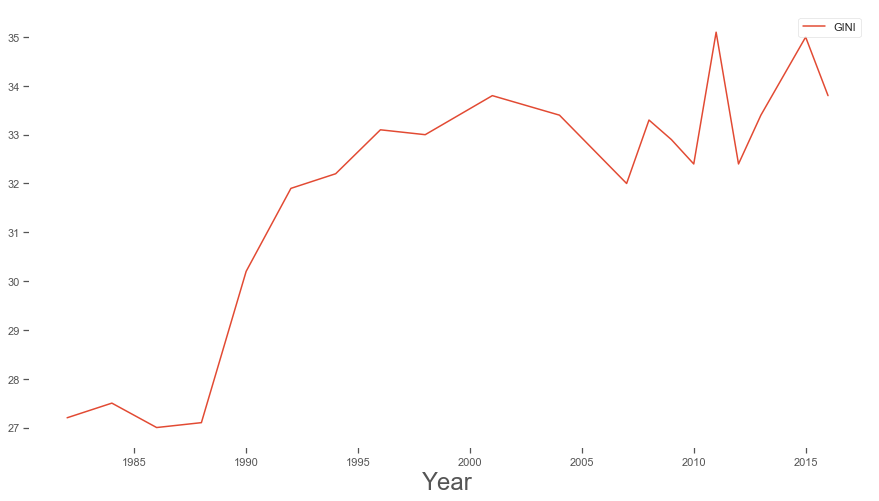

In [42]:
_ = sns.kdeplot(nz_by_indicators.GINI, cumulative=True, label='CDF')
_ = nz_by_indicators[['GINI']].hist(bins=int(9), density=True, alpha=0.2, color='grey', sharex=True)
_ = plot_trend(nz_by_indicators[['GINI']], '').set_ylabel('')

A few things are worth noting

* For the last 35 years, GINI index of New Zealand presents a generally increasing trend, with a leap from less than 28 to greater than 32, which happened around 1988-1993
* GINI index of 20 percent of years are less than 28, which happens in 1982-1988
* GINI index of 99 percent of years are less than 36 

#### 3.2 EDA on Gini vs indictors from poverty and Income 

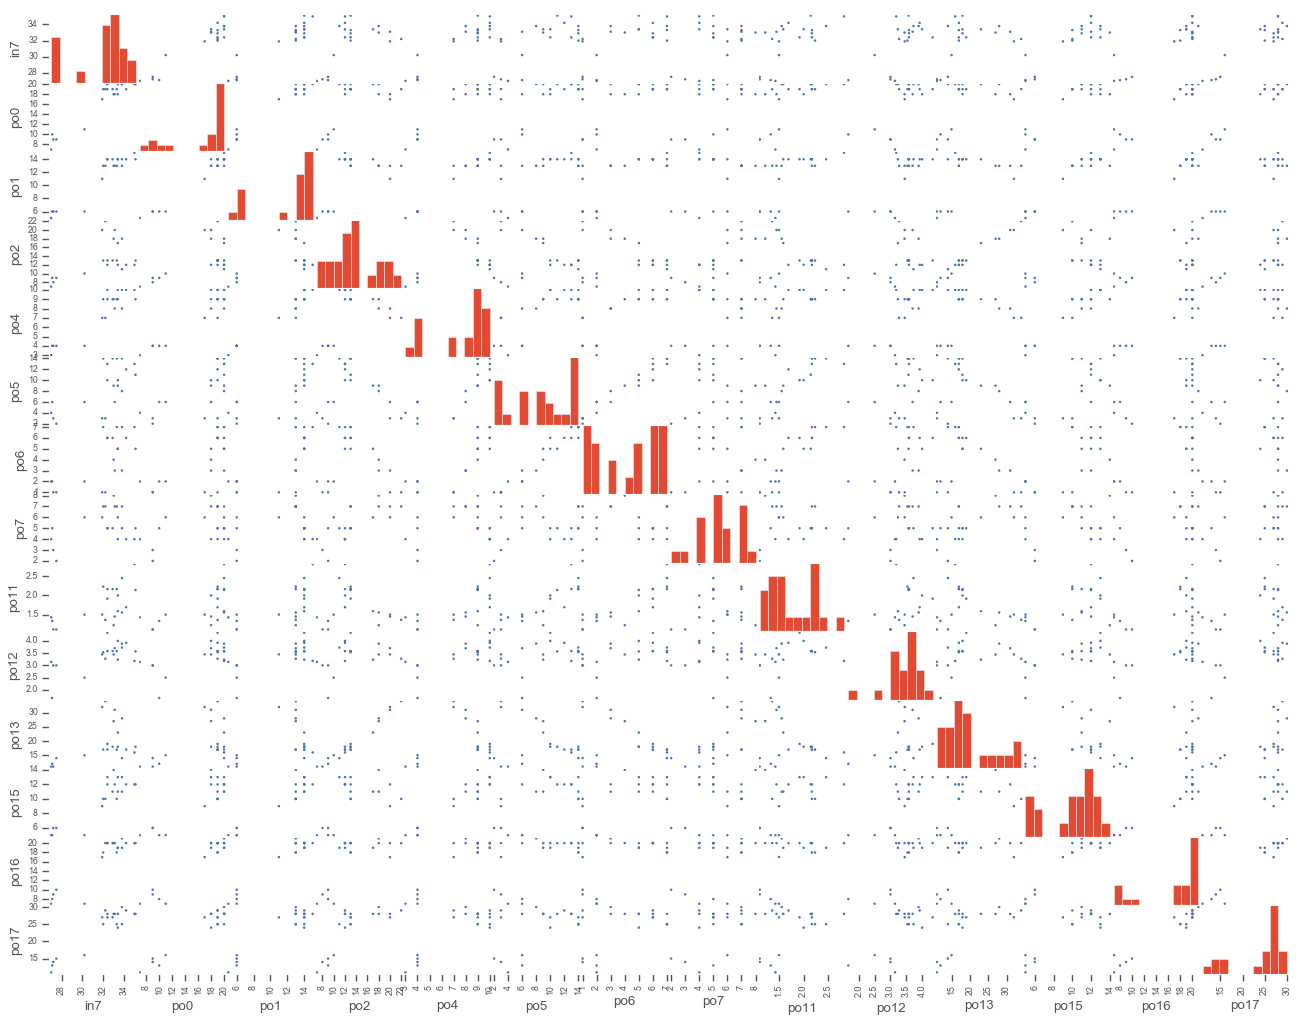

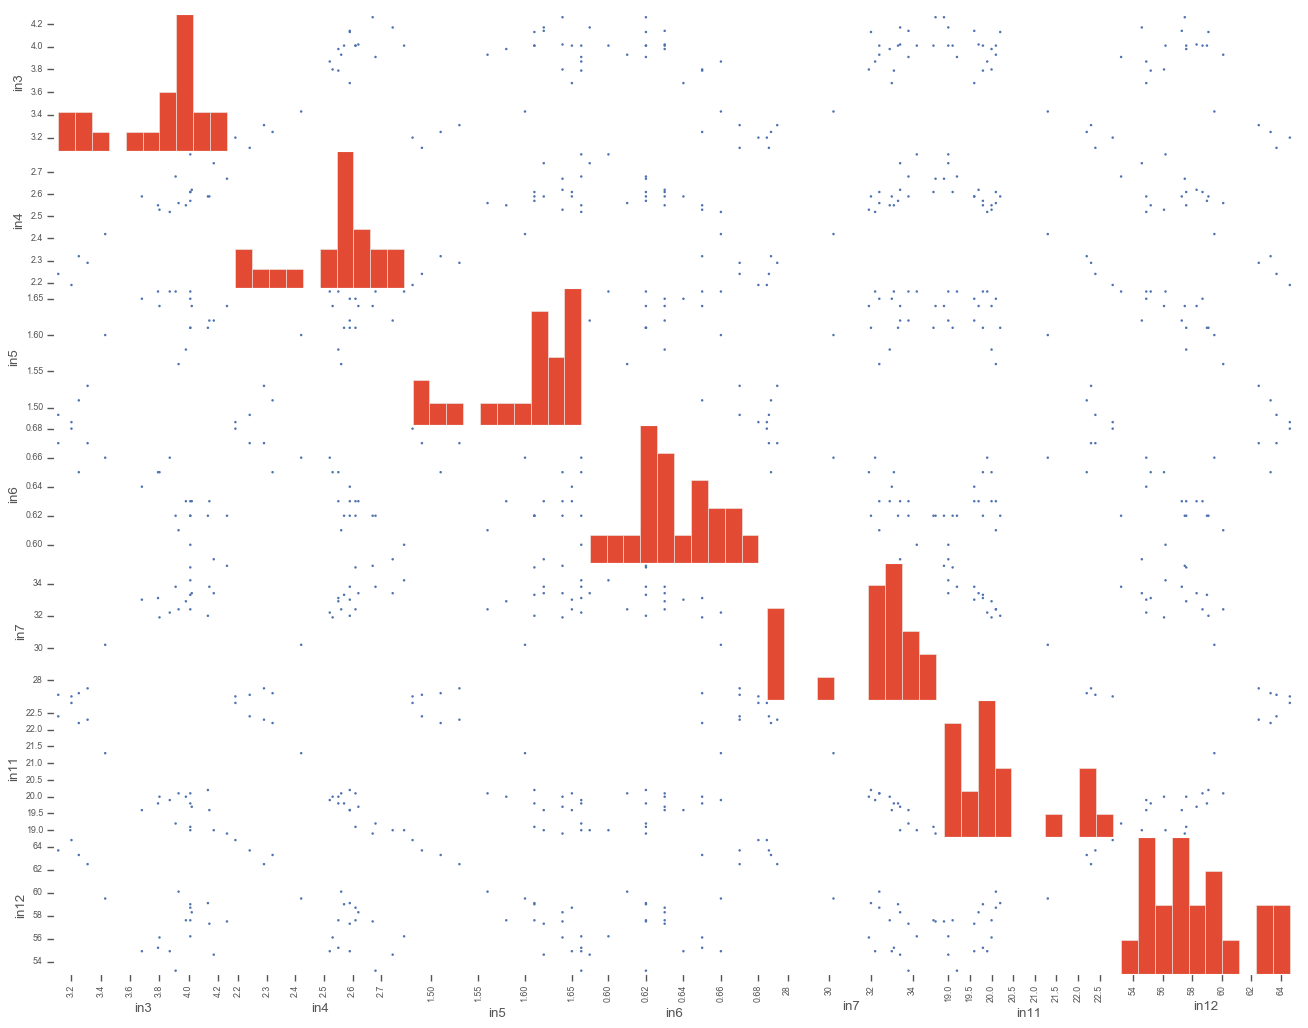

In [51]:
rcParams['font.size'] = 10
for topic in ['p', 'i']:
    _ = pd.plotting.scatter_matrix(nz_by_aliases[[c for c in nz_by_aliases.columns.tolist() if c[0] == topic or c == 'in7']], alpha=1, figsize=(20, 15))  
rcParams['font.size'] = 20

In [239]:
# Lookup for the feature aliases used in the matrices above 
#documentation[documentation.sheet.isin(['po', 'in'])][['alias', 'Column name in dataset', 'Indicator name', 'Indicator name (alternative)', 'sheet']].head()

Serveral relationships between GINI and other indicators can be found from the matraces above
 * in7 vs po0  i.e. GIni vs Poverty, 60% ML
 * in7 vs po4  i.e. GIni vs Poverty, 40% AL
 * in7 vs po12 i.e. GIni vs Poverty risk ratio, 50% AL, solo parent
 * in7 vs in11 i.e. GIni vs Lower deciles income share

Below we are focusing on two indicators that are 'Poverty, 60% ML' and 'Suicides'

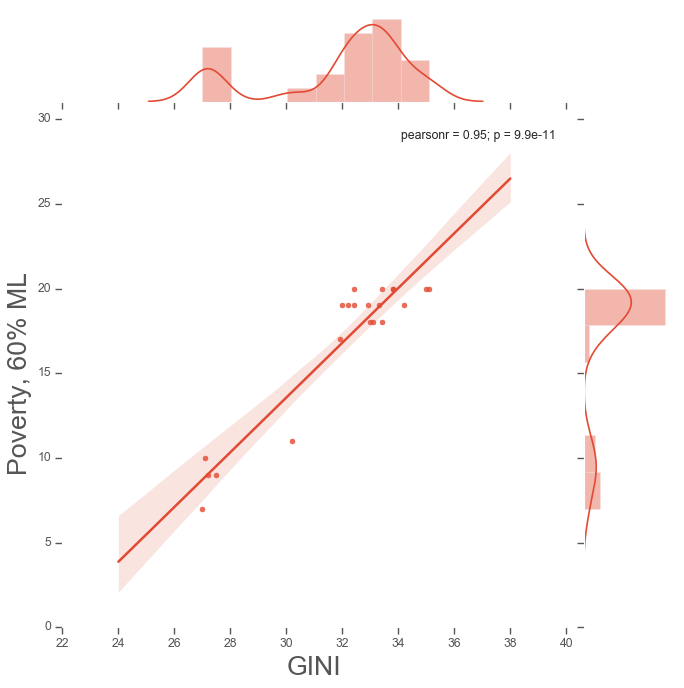

In [54]:
_ = sns.jointplot('GINI', 'Poverty, 60% ML', nz_by_indicators, kind='reg', height=9).annotate(stats.pearsonr)

* **Poverty, 60% ML**, as a widely used indicator of poverty, presents a strong positive linear relationship with GINI. Such correlation is also indicated by the Pearson's correlation r. In the plot above its value is **0.95** .  

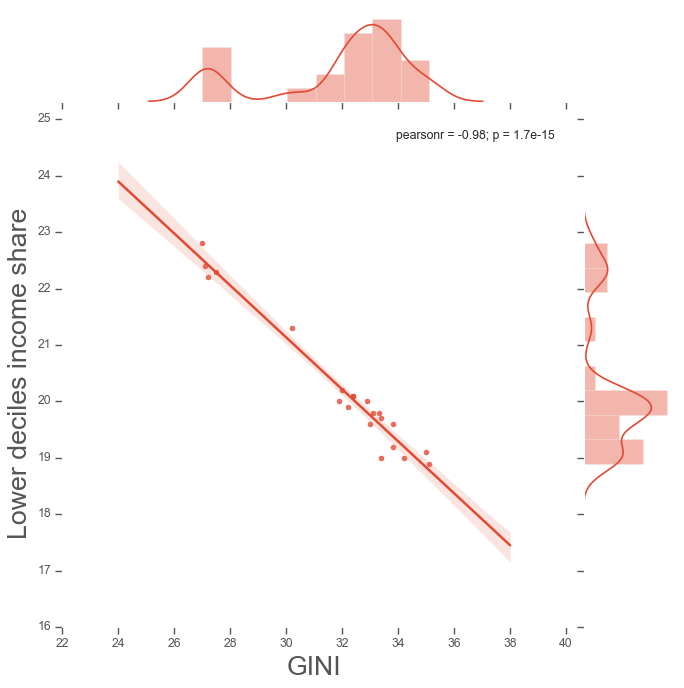

In [55]:
_ = sns.jointplot('GINI', 'Lower deciles income share', nz_by_indicators, kind='reg', height=9).annotate(stats.pearsonr)

* In contrast, with Pearson's correlation r equals to **-0.98** , the indicator **Lower deciles income share** shows a nearly perfect linear relationship with GINI.

### 4 Conclusion

For the last 35 years, GINI index of New Zealand presents a generally increasing trend, with a leap around 1988-1993. In addition to the trend, several meaningful relationships have been found between GINI index and indicators of poverty and income. For instance 'GINI vs Poverty, 60% ML' shows a strong positive correlation, 'GINI vs Lower deciles income share' a clear negative correlation.